In [ ]:
r_max = 1 #5, 3, 1
use_true_Jacobians = False
use_true_x0 = True
x_posterior_0 = np.array([10, 8.9, 0.1])

In [ ]:
from google.colab import drive
import scipy
import numpy as np
from matplotlib import pyplot as plt, patches as mpatches
import math
from google.colab import files
import matplotlib.animation as animation

from matplotlib.patches import Ellipse
import seaborn as sns




drive.mount('/content/drive')
S=scipy.io.loadmat('/content/drive/My Drive/AER1513/A2/dataset2.mat')



b = S['b'].flatten()
l = S['l']
om = S['om'].flatten()
r = S['r'].flatten()
t = S['t'].flatten()
th_true = S['th_true'].flatten()
true_valid = S['true_valid'].flatten()
v = S['v'].flatten()
x_true = S['x_true'].flatten()
y_true = S['y_true'].flatten()

b_var = S['b_var'][0][0] #0.00067
d = S['d'][0][0]
om_var = S['om_var'][0][0]
r_var = S['r_var'][0][0] #0.0009
v_var = S['v_var'][0][0]

T = 0.1 #sampling period

if use_true_x0:
  x_posterior_0 = [x_true[0], y_true[0], th_true[0]]

#Assume no correlation between radius variance and theta variance, off-diagonal matrices are 0
w = np.array([[v_var], [om_var]]) #2x1
n = np.array([[r_var], [b_var]]) #2x1

Q = np.array([[v_var, 0], [0, om_var]]) # motion model, m^2/s^2, rad^2/s^2
R = np.array([[r_var, 0], [0, b_var]]) #measurement noise, m^2, rad^2


K = t.size

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Initialize x and P and KG
P_pri = np.zeros((K, 3, 3))
P_pos = np.zeros((K, 3, 3))
x_pri = np.zeros((K, 3))
x_pos = np.zeros((K, 3))
np.fill_diagonal(P_pos[0], [1, 1, 0.1])
x_pos[0] = x_posterior_0

F = np.zeros((K-1, 3, 3))
F_t = np.zeros((K-1, 3, 3))


R_prime = np.copy(R)
for k in range(1, K):
  if use_true_Jacobians:
    F[k-1] = np.array([[1, 0, -T*math.sin(th_true[k-1])*v[k]],
                       [0, 1, T*math.cos(th_true[k-1])*v[k]],
                       [0, 0, 1]
                      ])
    F_t[k-1] = np.transpose(F[k-1])
    w_mat = np.array([[math.cos(th_true[k-1]), 0],
                      [math.sin(th_true[k-1]),0],
                      [0, 1]]) #3x2
  else:
    F[k-1] = np.array([[1, 0, -T*math.sin(x_pos[k-1][2])*v[k]],
                       [0, 1, T*math.cos(x_pos[k-1][2])*v[k]],
                       [0, 0, 1]
                      ])
    F_t[k-1] = np.transpose(F[k-1])
    w_mat = np.array([[math.cos(x_pos[k-1][2]), 0],
                      [math.sin(x_pos[k-1][2]),0],
                      [0, 1]]) #3x2

  w_mat_t = np.transpose(w_mat)
  Q_prime = T **2 * np.matmul(np.matmul(w_mat, Q, dtype = np.float64()), w_mat_t, dtype = np.float64())

  P_pri[k] = np.matmul((np.matmul(F[k-1], P_pos[k-1], dtype = np.float64())), F_t[k-1], dtype = np.float64()) + Q_prime
  x_pri[k][0] = x_pos[k-1][0] + T * math.cos(x_pos[k-1][2]) * v[k]
  x_pri[k][1] = x_pos[k-1][1] + T * math.sin(x_pos[k-1][2]) * v[k]
  new_theta = x_pos[k-1][2] + T * om[k]
  new_theta = (new_theta + math.pi) % (2 * math.pi) - math.pi
  x_pri[k][2] = new_theta

  if (true_valid[k]):
    xt = x_true[k]
    yt = y_true[k]
    tht = th_true[k]
    x = x_pri[k][0]
    y = x_pri[k][1]
    th = x_pri[k][2]

    R_diag_count = 0
    for j in range (0, 17):
      kl = (k) * 17 + j
      measured_range = r[kl]
      measured_phi = b[kl]

      if (0 < measured_range < r_max):
        xl = l[j][0]
        yl = l[j][1]
        if use_true_Jacobians:
          r_x = (xt - xl + d * math.cos(tht)) / (((xl - xt - d * math.cos(tht)) ** 2 + (yl - yt - d * math.sin(tht)) ** 2) ** (1/2))
          r_y = (yt - yl + d * math.sin(tht)) / (((xl - xt - d * math.cos(tht)) ** 2 + (yl - yt - d * math.sin(tht)) ** 2) ** (1/2))
          r_th = (d * math.cos(tht) * (yt - yl + d * math.sin(tht)) - d * math.sin(tht) * (xt - xl + d * math.cos(tht))) / (((xl - xt - d * math.cos(tht)) ** 2 + (yl - yt - d*math.sin(tht)) ** 2) ** (1/2))

          phi_x = (yl - yt - d * math.sin(tht)) / ((xl - xt - d*math.cos(tht)) ** 2 + (yl - yt - d * math.sin(tht)) ** 2)
          phi_y = (-xl + xt + d * math.cos(tht)) / ((xl - xt - d*math.cos(tht)) ** 2 + (yl - yt - d * math.sin(tht)) ** 2)
          phi_th = (-d * (math.cos(tht) * (xl - xt - d * math.cos(tht)) + math.sin(tht) * (yl - yt - d * math.sin(tht)))) / ((xl - xt - d * math.cos(tht)) ** 2 + (yl - yt - d*math.sin(tht)) ** 2) - 1

        else:
          r_x = (x - xl + d*math.cos(th)) / (((xl - x - d*math.cos(th)) ** 2 + (yl - y - d * math.sin(th)) ** 2) ** (1/2))
          r_y = (y - yl + d*math.sin(th)) / (((xl - x - d*math.cos(th)) ** 2 + (yl - y - d * math.sin(th)) ** 2) ** (1/2))
          r_th = (d * math.cos(th) * (y - yl + d * math.sin(th)) - d * math.sin(th) * (x - xl + d * math.cos(th))) / (((xl - x - d * math.cos(th)) ** 2 + (yl - y - d * math.sin(th)) ** 2) ** (1/2))

          phi_x = (yl - y - d*math.sin(th)) / ((xl - x - d*math.cos(th)) ** 2 + (yl - y - d * math.sin(th)) ** 2)
          phi_y = (-xl + x + d*math.cos(th)) / ((xl - x - d*math.cos(th)) ** 2 + (yl - y - d * math.sin(th)) ** 2)
          phi_th = (-d * (math.cos(th) * (xl - x - d * math.cos(th)) + math.sin(th) * (yl - y - d * math.sin(th)))) / ((xl - x - d * math.cos(th)) ** 2 + (yl - y - d * math.sin(th)) ** 2) - 1

        #G stack
        G_temp = np.array([[r_x, r_y, r_th],
              [phi_x, phi_y, phi_th]])


        #g computation
        pred_r = math.sqrt((xl- x - d * math.cos(th)) ** 2 + (yl- y - d * math.sin(th)) ** 2)
        pred_phi = math.atan2(yl - y - d * math.sin(th), xl - x - d * math.cos(th)) - th
        pred_phi = (pred_phi + math.pi) % (2 * math.pi) - math.pi

        #innovation
        rad_diff = measured_phi - pred_phi + math.pi
        rad_diff = (rad_diff % (2 * math.pi)) - math.pi

        innov_temp = np.array([[measured_range - pred_r], [rad_diff]])


        if (R_diag_count == 0):
          innov = np.copy(innov_temp)
          G = np.copy(G_temp)
        else:
          innov = np.vstack((innov, innov_temp))
          G = np.vstack((G,G_temp))

        #R diag
        R_diag_count = R_diag_count + 2


    if R_diag_count:
      R_prime = np.zeros((R_diag_count, R_diag_count))
      np.fill_diagonal(R_prime, np.diag(R))
      G_t = np.transpose(G)

      inv_temp = np.linalg.inv(np.matmul((np.matmul(G, P_pri[k], dtype = np.float64())), G_t, dtype = np.float64()) + R_prime)
      KG = np.matmul((np.matmul(P_pri[k], G_t, dtype = np.float64())), inv_temp, dtype = np.float64())
      P_pos[k] = np.matmul((np.eye(3) - np.matmul(KG, G, dtype = np.float64())), P_pri[k], dtype = np.float64())
      x_pos[k] = x_pri[k] + np.matmul(KG, innov, dtype = np.float64()).flatten()

      x_pos[k][2] = (x_pos[k][2] + math.pi) % (2 * math.pi) - math.pi

    else:
      x_pos[k] = x_pri[k]
      P_pos[k] = P_pri[k]
  else:
    x_pos[k] = x_pri[k]
    P_pos[k] = P_pri[k]

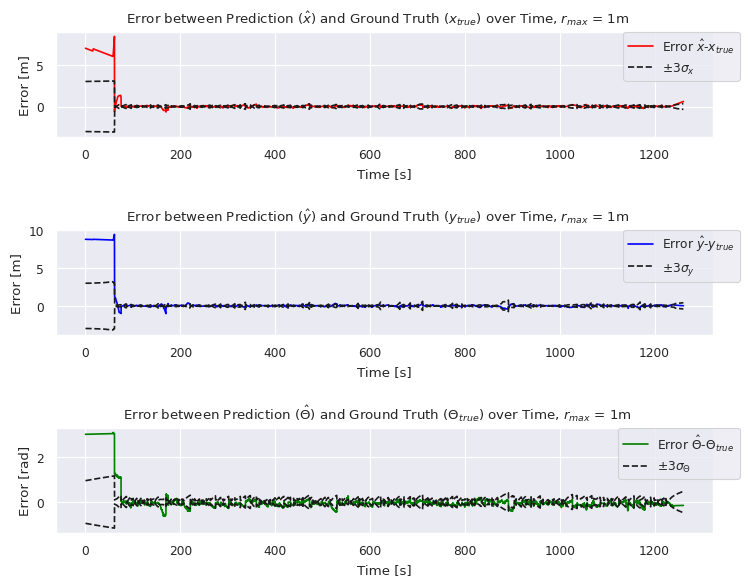

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

error_x = (x_pos[:, 0] - x_true).tolist()

std3_x = 3*np.power(P_pos[:, 0, 0], 0.5)
std3_plus_x = std3_x
std3_minus_x = -std3_x

ax1.set_title("  Error between Prediction ($\hat{x}}$) and Ground Truth ($x_{true}$) over Time, $r_{max}$ = %im      " % r_max)
ax1.plot(t, error_x, color="red", label="Error $\hat{x}}$-$x_{true}$")

ax1.plot(t, std3_plus_x, "k--", label="$\pm 3\sigma _x$")
ax1.plot(t, std3_minus_x, "k--")
ax1.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
ax1.grid(True)
# ax1.set_ylim((-0.25, 0.25))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Error [m]")




error_y = (x_pos[:, 1] - y_true).tolist()

std3_y = 3*np.power(P_pos[:, 1, 1], 0.5)
std3_plus_y = std3_y
std3_minus_y = -std3_y

ax2.set_title("  Error between Prediction ($\hat{y}}$) and Ground Truth ($y_{true}$) over Time, $r_{max}$ = %im      " % r_max)
ax2.plot(t, error_y, color="blue", label="Error $\hat{y}}$-$y_{true}$")

ax2.plot(t, std3_plus_y, "k--", label="$\pm 3\sigma _y$")
ax2.plot(t, std3_minus_y, "k--")
ax2.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
ax2.grid(True)
# ax2.set_ylim((-0.25, 0.25))

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Error [m]")




error_th = (x_pos[:, 2] - th_true).tolist()
for i in range(0,K): #-pi to pi
  angle1 = x_pos[i][2]
  angle2 = th_true[i]

  rad_diff = angle1 - angle2 + math.pi
  value = (rad_diff % (2 * math.pi)) - math.pi
  error_th[i] = value

std3_th = 3*np.power(P_pos[:, 2, 2], 0.5)
std3_plus_th = std3_th
std3_minus_th = -std3_th

ax3.set_title("  Error between Prediction ($\hat{\Theta}}$) and Ground Truth ($\Theta_{true}$) over Time, $r_{max}$ = %im      " % r_max)
ax3.plot(t, error_th, color="green", label="Error $\hat{\Theta}}$-${\Theta}_{true}$")

ax3.plot(t, std3_plus_th, "k--", label="$\pm 3\sigma _{\Theta}$")
ax3.plot(t, std3_minus_th, "k--")
ax3.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Error [rad]")
ax3.grid(True)
# ax3.set_ylim((-0.25, 0.25))
fig.tight_layout(pad=0.5)
fig.set_size_inches(7.5, 6, forward=True)
fig.savefig("Errors.png")
fig.show()

In [ ]:
fig.show()

In [ ]:
unit = 0.8
offset = 0.1
x_tar = np.zeros(K)
y_tar = np.zeros(K)
x_tar_t = np.zeros(K)
y_tar_t = np.zeros(K)
for i in range (0,K):
  x_tar[i] = unit*math.cos(x_pos[i][2])
  y_tar[i] = unit*math.sin(x_pos[i][2])
  x_tar_t[i] = unit*math.cos(th_true[i])
  y_tar_t[i] = unit*math.sin(th_true[i])



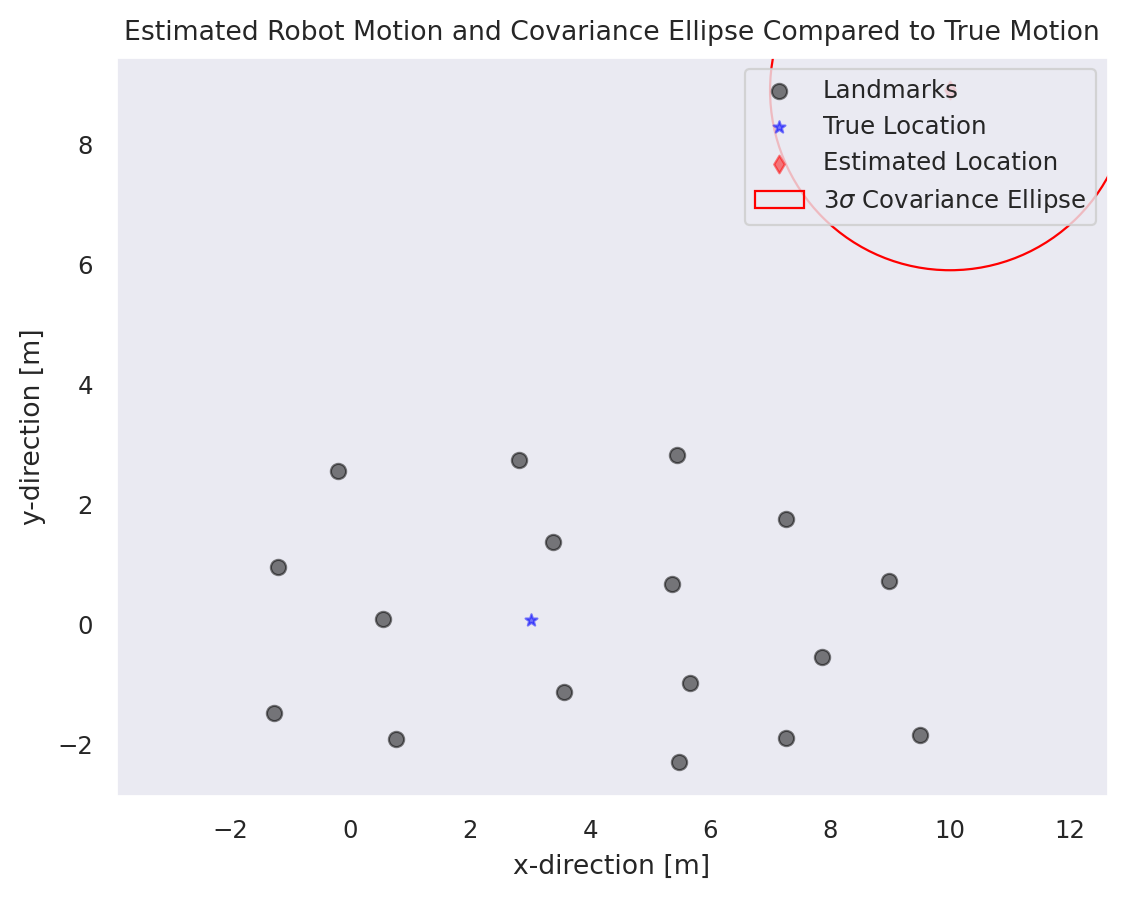

In [ ]:
sns.set_theme(context = "paper", style="dark")

fig, ax = plt.subplots(dpi=200)
xx = l[:, 0]
yy = l[:, 1]

patch1 = mpatches.FancyArrow(x_pos[0][0] + offset*math.cos(x_pos[0][2]), x_pos[0][1] + offset*math.sin(x_pos[0][2]), x_tar[0], y_tar[0], color = 'red', width = 0.05, head_width = 0.1, length_includes_head = True )
patch2 = mpatches.FancyArrow(x_true[0] + offset*math.cos(th_true[0]), y_true[0] + offset*math.sin(th_true[0]), x_tar_t[0], y_tar_t[0], color = 'blue', width = 0.05, head_width = 0.1, length_includes_head = True )

ax.scatter(xx,yy, color="black", label="Landmarks", alpha=0.5, s = 30)
scat_true = ax.scatter(x_true[0], y_true[0], c="blue", s=20, label='True Location', alpha=0.5, marker = "*")
scat_pred = ax.scatter(x_pos[0][0], x_pos[0][1], c="red", s=20, label='Estimated Location', alpha=0.5, marker = "d")
ax.set(xlabel='x-direction [m]', ylabel='y-direction [m]')
ax.set_title("Estimated Robot Motion and Covariance Ellipse Compared to True Motion")
ax.set_xlim((-2.5, 12))
ax.set_ylim((-3, 4))



# cov = np.zeros((2,2))
# np.fill_diagonal(cov, [1, 1])
cov = P_pos[0][0:2, 0:2]
lambda_, vv = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
ell = Ellipse(xy=(x_pos[0][0], x_pos[0][1]),
              width=lambda_[0]*3*2, height=lambda_[1]*3*2,
              angle=np.rad2deg(np.arccos(vv[0, 0])), color = 'red', label='3$\sigma$ Covariance Ellipse')
ell.set_facecolor('none')
ax.add_artist(ell)
ax.legend(loc = 'upper right')

plt.axis('equal')
plt.show()

std_dev = 3 #which standard deviation
a1 = ax.add_patch(patch1)
a2 = ax.add_patch(patch2)

def update(frame):
    frame = frame*20
    x = x_pos[frame][0]
    y = x_pos[frame][1]
    x_t = x_true[frame]
    y_t = y_true[frame]

    cov = P_pos[frame][0:2, 0:2]
    lambda_, vv = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ell.set_angle(np.rad2deg(np.arccos(vv[0, 0])))
    ell.set_center((x_pos[frame][0], x_pos[frame][1]))
    ell.set_height(lambda_[1]*std_dev*2) #Check for multiply by 3
    ell.set_width(lambda_[0]*std_dev*2)

    scat_true.set_offsets([x_t, y_t])
    scat_pred.set_offsets([x, y])
    patch1.set_data(x = x_pos[frame][0] + offset*math.cos(x_pos[frame][2]), y = x_pos[frame][1] + offset*math.sin(x_pos[frame][2]), dx =  x_tar[frame], dy = y_tar[frame])
    patch2.set_data(x = x_true[frame] + offset*math.cos(th_true[frame]), y = y_true[frame] + offset*math.sin(th_true[frame]), dx = x_tar_t[frame], dy = y_tar_t[frame])

    return (scat_true, scat_pred, ell, patch1, patch2)

#For animation, frames = K
ani = animation.FuncAnimation(fig=fig, func=update, frames=6, interval=100)
plt.show()
ani.save(filename="EKFAnimation.mp4", writer="ffmpeg")
